In [1]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Balance = in_degree - out_degree
#influence = in_degree / (in_degree + out_degree)

train_df = pd.DataFrame(columns=["txid", "value", "fee", "in_degree", "nu_out_degree", "balance", "influence", "z_score"])

with open(r"C:\Users\jaske\Downloads\rpc_api_data\842600.json", "r") as file:
    data = json.load(file)
block_number = data["block_info"]["height"]
transactions = data["transactions"][1:]

df = pd.DataFrame()
for transaction in transactions:
    df = df._append({"txid": transaction["txid"], "value": float(transaction["receiver_total_received"]), "fee": float(transaction["fee"]),
            "in_degree": transaction["in_degree"], "nu_out_degree": transaction["nu_out_degree"],
            "balance": transaction["in_degree"] - transaction["nu_out_degree"],
            "influence": transaction["in_degree"] / (transaction["in_degree"] + transaction["nu_out_degree"])}, 
                                ignore_index=True)
df["z_score"] = (df["value"] - df["value"].mean()) / df["value"].std()
train_df = pd.concat([train_df, df])
        
x = train_df[["value", "fee", "in_degree", "nu_out_degree", "balance", "influence", "z_score"]]

# Distance Plot to Nearest Neighbour

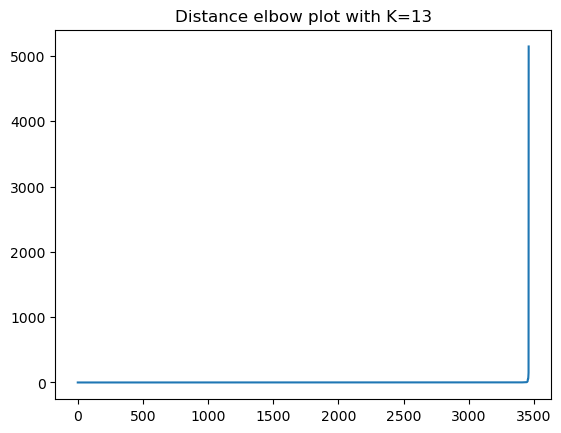

In [28]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=13)
neighbors_fit = neighbors.fit(x)
distances, indices = neighbors_fit.kneighbors(x)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Distance elbow plot with K=13")
plt.show()

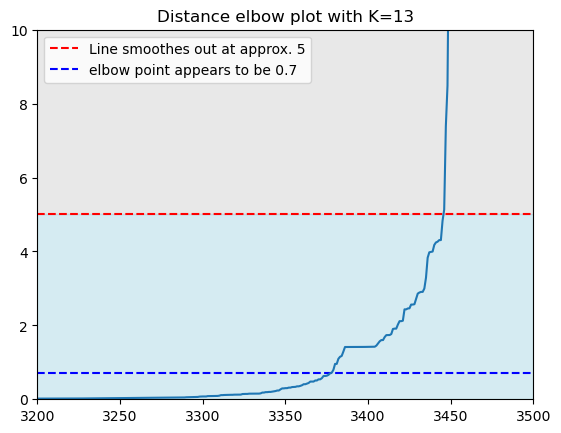

In [30]:
plt.axhline(y=5, color="r", linestyle="--", label="Line smoothes out at approx. 5")
plt.axhline(y=0.7, color="b", linestyle="--", label="elbow point appears to be 0.7")
plt.axhspan(ymin=5, ymax=10, color='lightgrey', alpha=0.5)
plt.axhspan(ymin=0, ymax=5, color='lightblue', alpha=0.5)
plt.plot(distances)
plt.title("Distance elbow plot with K=13")
plt.xlim(3200, 3500)
plt.ylim(0, 10)
plt.legend()
plt.show()

### Rule of Thumb MinPts is set to >= (number_of_dimensions + 1) or (2*number_of_dimensions)

In [15]:
eps_values = np.arange(0.1, 6.0, 0.1)
MinPts_values = range(7, 15)
reading_df = pd.DataFrame(columns=["eps", "minpoints", "number_of_clusters", "silhouette_score", "clusters", "anomalies", "total_anomalies"])

for eps in eps_values:
    for points in MinPts_values:
        dbscan = DBSCAN(eps=eps, min_samples=points)
        clusters = dbscan.fit_predict(x)
        reading_df = reading_df._append({"eps": eps, "minpoints": points, "number_of_clusters": len(np.unique(clusters)), "silhouette_score": silhouette_score(x, clusters), 
                                         "clusters": np.unique(clusters), "anomalies": np.count_nonzero(clusters == -1), "total_anomalies": np.count_nonzero(clusters != 0)}, ignore_index=True)

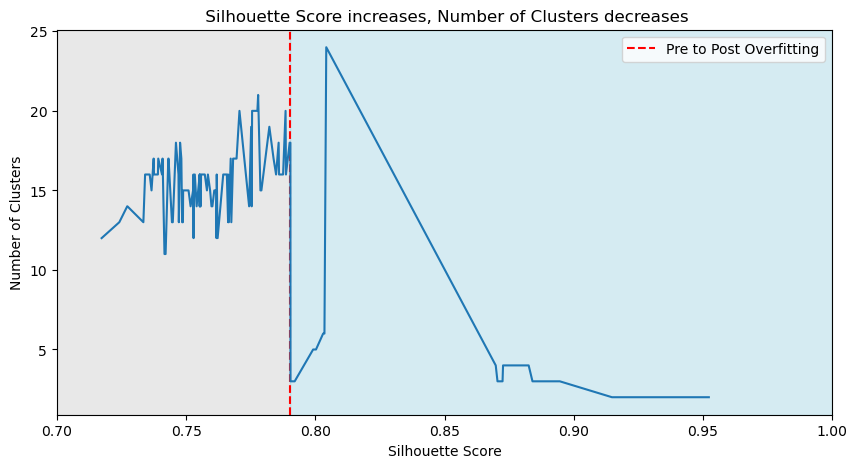

In [16]:
reading_df.sort_values(by=["silhouette_score"], ascending=True, inplace=True)

plt.figure(figsize=(10,5))
plt.axvline(x=0.79, color="r", linestyle="--", label="Pre to Post Overfitting")
plt.axvspan(xmin=0.7, xmax=0.79, color='lightgrey', alpha=0.5)
plt.axvspan(xmin=0.79, xmax=1.0, color='lightblue', alpha=0.5)
plt.plot(reading_df["silhouette_score"], reading_df["number_of_clusters"])
plt.xticks(np.arange(0.7, 1.0, 0.05))
plt.xlim(0.7, 1.0)
plt.title(" Silhouette Score increases, Number of Clusters decreases")
plt.xlabel("Silhouette Score")
plt.ylabel("Number of Clusters")
plt.legend(loc="upper right")
plt.show()

In [17]:
reading_df.sort_values(by=["silhouette_score", "anomalies"], ascending=False, inplace=True)
reading_df.to_csv(r"C:\Users\jaske\Downloads\silhouette.csv", index=False)
reading_df.head()

,eps,minpoints,number_of_clusters,silhouette_score,clusters,anomalies,total_anomalies
467,5.9,10,2,0.952313,"[-1, 0]",65,65
450,5.7,9,2,0.952313,"[-1, 0]",65,65
459,5.8,10,2,0.952313,"[-1, 0]",65,65
458,5.8,9,2,0.952313,"[-1, 0]",65,65
466,5.9,9,2,0.952313,"[-1, 0]",65,65


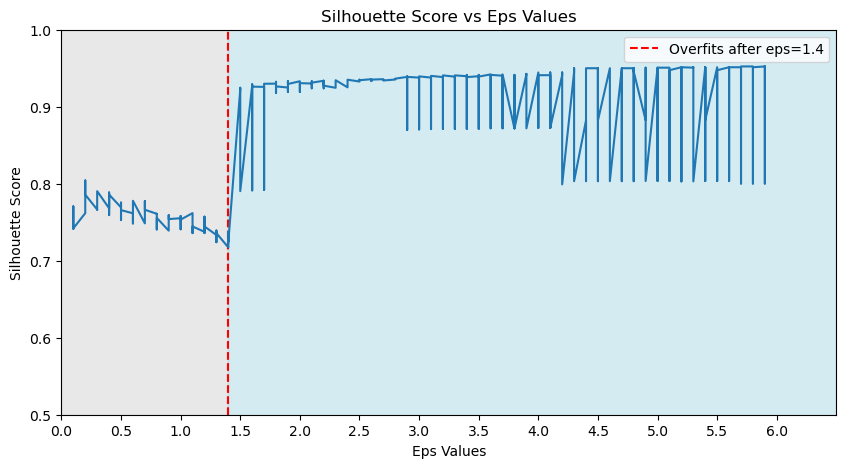

In [18]:
reading_df.sort_values(by=["eps"], ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
plt.axvspan(xmin=0, xmax=1.4, color='lightgrey', alpha=0.5)
plt.axvspan(xmin=1.4, xmax=6.5, color='lightblue', alpha=0.5)
plt.axvline(x=1.4, color="r", linestyle="--", label="Overfits after eps=1.4")
plt.plot(reading_df["eps"], reading_df["silhouette_score"], linestyle="-")

plt.xticks(np.arange(0.0, 6.5, 0.5))
plt.xlim(0.0, 6.5)
plt.title("Silhouette Score vs Eps Values")
plt.xlabel("Eps Values")
plt.ylabel("Silhouette Score")
plt.ylim(0.5,1)
plt.legend()
plt.show()

In [19]:
minpoints_df = reading_df.groupby("minpoints")["silhouette_score"].agg(["min", "mean", "max"]).reset_index()
minpoints_df.columns = ["minpoints", "min", "mean", "max"]

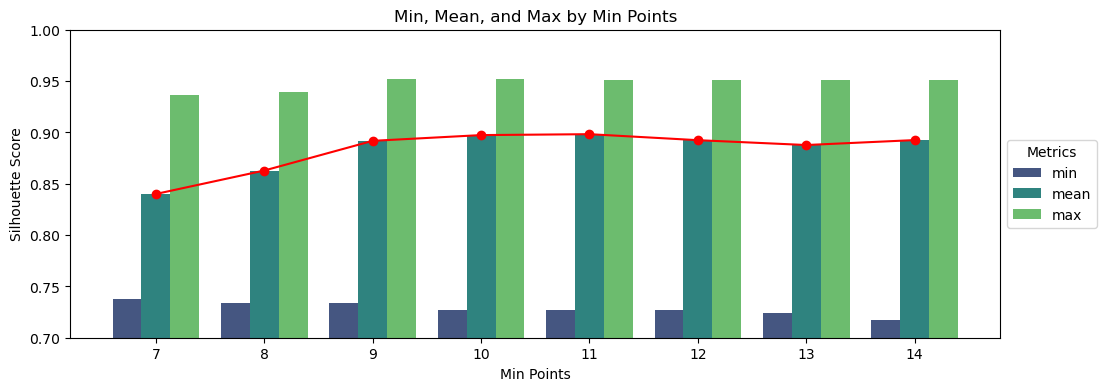

In [20]:
df_long = minpoints_df.melt(id_vars="minpoints", var_name="metric", value_name="value")

plt.figure(figsize=(12, 4))

ax = sns.barplot(x="minpoints", y='value', hue="metric", data=df_long, palette="viridis")
xticks = ax.get_xticks()
plt.plot(xticks, minpoints_df["mean"], color='red', marker='o')

plt.title("Min, Mean, and Max by Min Points")
plt.xlabel("Min Points")
plt.ylabel("Silhouette Score")
plt.legend(title="Metrics", bbox_to_anchor=(1, 0.5), loc="center left")
plt.ylim(0.7, 1)
plt.show()

# Choosing Value of Min Points = 8, eps between [0, 1.4] forming large number of clusters

### eps = 0.6, Min Points = 8, forms 17 Clusters

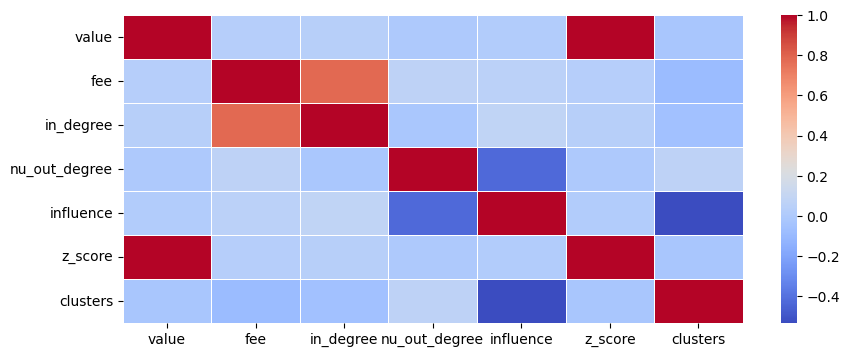

In [21]:
x = train_df[["value", "fee", "in_degree", "nu_out_degree", "influence", "z_score"]]

dbscan = DBSCAN(eps=0.6, min_samples=8)
clusters = dbscan.fit_predict(x)
train_df["clusters"] = clusters
correlation_matrix = train_df[["value", "fee", "in_degree", "nu_out_degree", "influence", "z_score", "clusters"]].corr()

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.show()

## Influence, in_degree and fee are the parameters that effect the cluster formation the most

In [22]:
x = train_df[["value", "fee", "in_degree", "nu_out_degree", "balance", "influence", "z_score"]]
x_scaled = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

dbscan = DBSCAN(eps=0.6, min_samples=8)
clusters = dbscan.fit_predict(x)
train_df["cluster"] = clusters

train_df.sort_values(by=["cluster", "value", "in_degree"], ascending=[True, False, False], inplace=True)
train_df.to_csv(r"C:\Users\jaske\Downloads\clusters.csv", index=False)

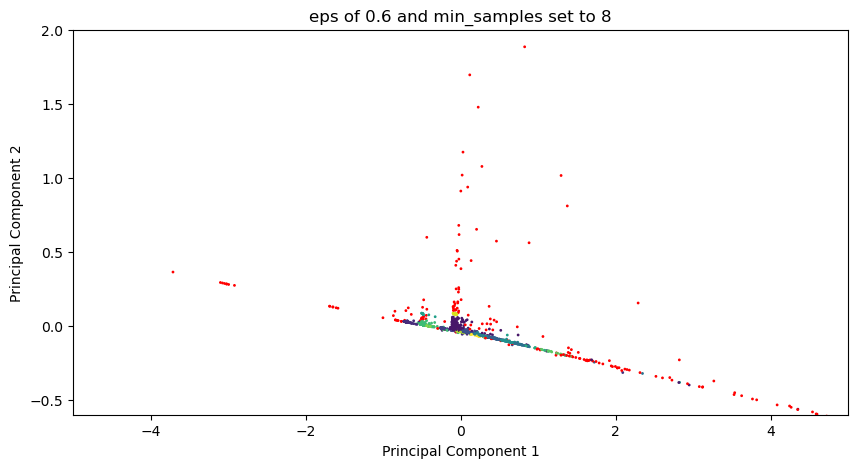

In [23]:
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(clusters) - 1))
viridis_colors = [(r, g, b, 1) for r, g, b, _ in viridis_colors]
colors = ["red"] + viridis_colors
cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(10, 5))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap=cmap, s=1, label=clusters)
plt.title("eps of 0.6 and min_samples set to 8")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(-5, 5)
plt.ylim(-0.6, 2)
plt.show()

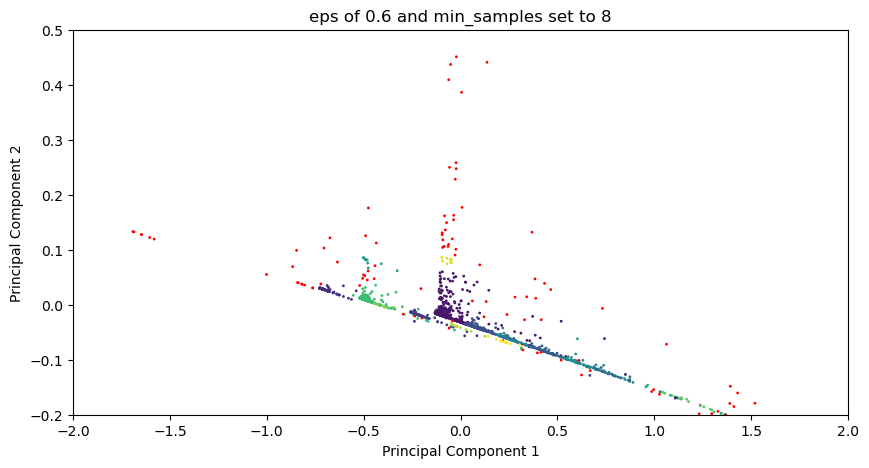

In [24]:
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(clusters) - 1))
viridis_colors = [(r, g, b, 1) for r, g, b, _ in viridis_colors]
colors = ["red"] + viridis_colors
cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(10, 5))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap=cmap, s=1, label=clusters)
plt.title("eps of 0.6 and min_samples set to 8")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(-2, 2)
plt.ylim(-0.2, 0.5)
plt.show()

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(x_scaled)

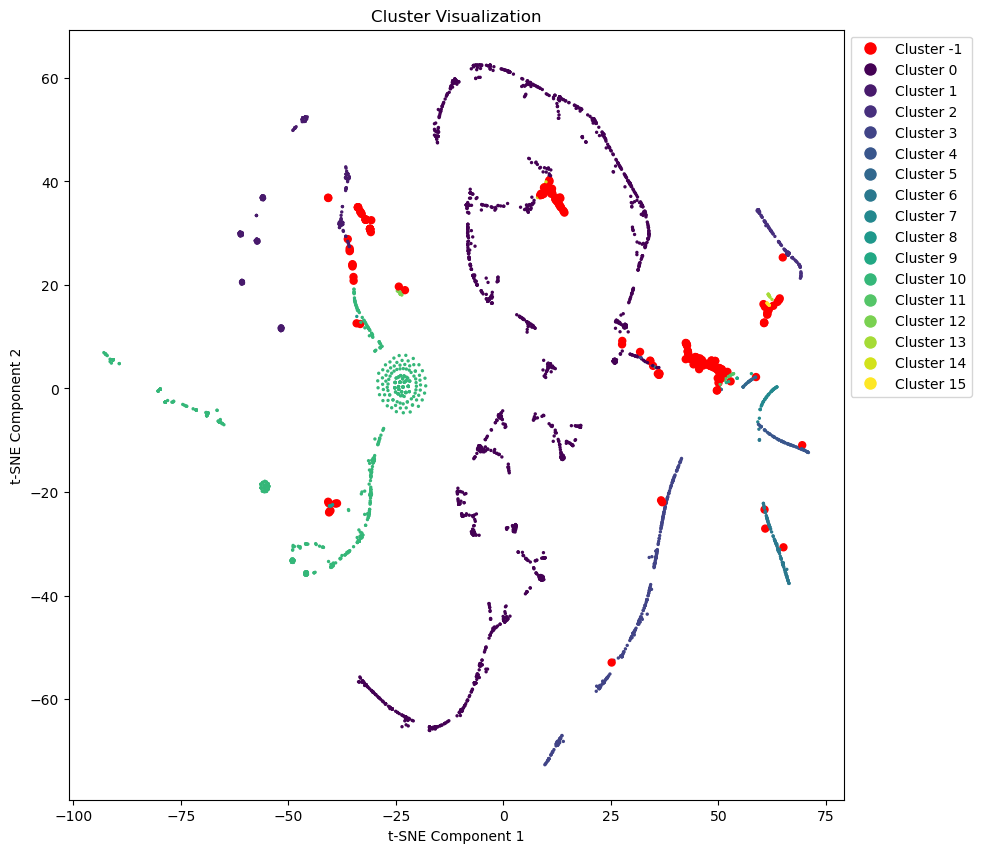

In [26]:
unique_clusters = np.unique(clusters)
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters) - 1))
viridis_colors = [(r, g, b, 1) for r, g, b, _ in viridis_colors]
colors = ["red"] + viridis_colors
cmap = mcolors.ListedColormap(colors)

sizes = np.array([2] * len(clusters))
sizes[clusters == -1] = 25  

plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap=cmap, s=sizes)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Cluster Visualization")

# Creating a custom legend
handles = []
for cluster in unique_clusters:
    color = cmap(unique_clusters.tolist().index(cluster))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                              markerfacecolor=color, markersize=10))

plt.legend("Clusters", handles=handles, bbox_to_anchor=(1, 1))
plt.show()